# Install yfinance using pip:





In [1]:
!pip install yfinance --upgrade --no-cache-dir

# Predict the stock prices using LSTM

In [2]:
#Import all the required libraries.
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Load the Apple stock price dataset from yahoo finance

Website: https://finance.yahoo.com/quote/AAPL/history?p=AAPL

In [3]:
stock_data = yf.download('AAPL', start='2016-01-01', end='2024-03-25')
stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,23.946918,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.346823,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,22.889938,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,21.923878,324377600
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.039803,283192000


# Visualizing Stock Prices History

Use the Matplotlib plot method to create a line chart for historical close prices of AAPL.

Text(0, 0.5, 'Prices ($)')

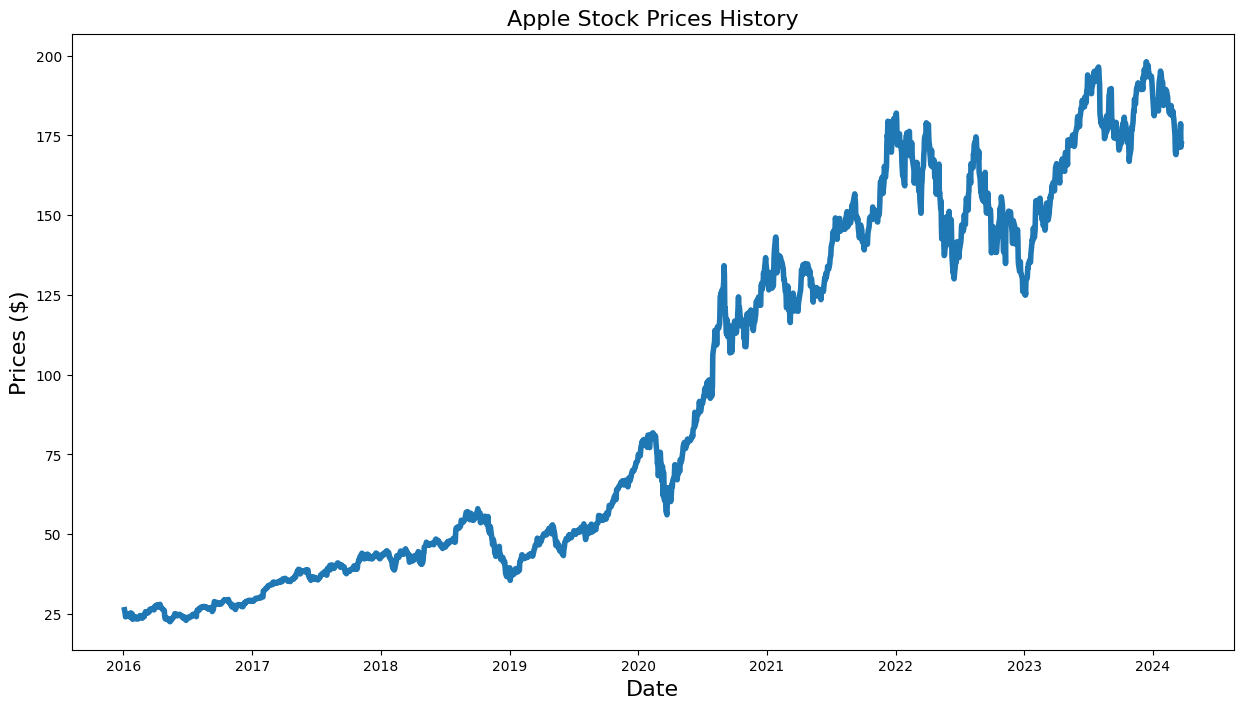

In [4]:
plt.figure(figsize=(15, 8))
plt.title('Apple Stock Prices History', fontsize = 16)
plt.plot(stock_data['Close'], linewidth = 4)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Prices ($)', fontsize = 16)

The AAPL shows an upward trend over the last five years.

# Data preprocessing

Prepare train and test datasets from the given dataset

In [5]:
#Extract the closing prices from stock data and convert it into a number series
close_prices = stock_data['Close']
values = close_prices.values ###convert the dataframe into a numpy
print(values.shape)

# 80% of the dataset selected for training # math.ceil ensure that data size is rounded upto an integer
training_data_len = math.ceil(len(values)* 0.8)

# apply min max scaler to normalize the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

#reshape the normalized data into a two-dimensional array for LSTM
scaled_data = scaler.fit_transform(values.reshape(-1,1))
print(scaled_data.shape)

# Use 80% dataset for training
train_data = scaled_data[0: training_data_len, :]

#Empty lists for a sequence of feature data (x_train) and a sequence of label data (y_train)
x_train = []
y_train = []

# Create a 60-days window of historical prices (i-60) as our feature data (x_train)
#following 60-days window as label data (y_train)
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

#convert x_train and y_train into a numpy array for feeding into the neural network
x_train, y_train = np.array(x_train), np.array(y_train)

#print the shape of training data
print("Before reshaping the shape of train data:", x_train.shape)


(2069,)
(2069, 1)
Before reshaping the shape of train data: (1596, 60)


# Reshape the data for LSTM to a three-dimensional array

The input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

<b>Samples</b>: One sequence is one sample. A batch is comprised of one or more samples.

<b>Time Steps</b>: One time step is one point of observation in the sample.

<b>Features</b>: One feature is one observation at a time step.

For more information check the following link:

https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

In [6]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape[0])
print(x_train.shape[1])
print("After reshaping of train data:", x_train.shape) # [samples, timesteps, features]


1596
60
After reshaping of train data: (1596, 60, 1)


# Prepare the test data

In [7]:
# extract the last 20% of the normalized/scaled dataset
test_data = scaled_data[training_data_len-60: , : ]

#create feature data (x_test) and label data (y_test) from the test set
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

#convert x_test to a numpy array
x_test = np.array(x_test)

#reshape x_test as [samples, timesteps, features]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(x_test.shape[0])
print(x_test.shape[1])
print("After reshaping of test data:", x_test.shape)

413
60
After reshaping of test data: (413, 60, 1)


# Build the LSTM Model

In [8]:
#Sequential model --> linear stack of layers
model = keras.Sequential()

#LSTM layer with 100 neurons
##An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output
#return sequence= True so that the output of the layer will be another sequence of the same length (3D input required for LSTM layers)
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))

#LSTM layer, return sequence= False, return the last output in the output sequence.
model.add(layers.LSTM(100, return_sequences=False))

#Dense layer 25 neurons
model.add(layers.Dense(25))

#output layer with 1 neuron
model.add(layers.Dense(1,activation='linear'))

#summary of network architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123751 (483.40 KB)
Trainable params: 123751 (483.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Compile and run the LSTM model

In [9]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error') #use default learning rate = 0.001
model.fit(x_train, y_train, batch_size= 32, epochs=50) ###train the model

Epoch 1/50
50/50 [==============================] - 6s 10ms/step - loss: 0.0099
Epoch 2/50
50/50 [==============================] - 0s 8ms/step - loss: 4.3687e-04
Epoch 3/50
50/50 [==============================] - 0s 8ms/step - loss: 4.3038e-04
Epoch 4/50
50/50 [==============================] - 0s 8ms/step - loss: 4.2067e-04
Epoch 5/50
50/50 [==============================] - 0s 8ms/step - loss: 4.1868e-04
Epoch 6/50
50/50 [==============================] - 0s 8ms/step - loss: 3.9321e-04
Epoch 7/50
50/50 [==============================] - 0s 9ms/step - loss: 4.2288e-04
Epoch 8/50
50/50 [==============================] - 0s 8ms/step - loss: 3.6845e-04
Epoch 9/50
50/50 [==============================] - 0s 8ms/step - loss: 3.8236e-04
Epoch 10/50
50/50 [==============================] - 0s 8ms/step - loss: 3.4737e-04
Epoch 11/50
50/50 [==============================] - 0s 8ms/step - loss: 3.4248e-04
Epoch 12/50
50/50 [==============================] - 0s 8ms/step - loss: 3.3814e-04
Epoc

In [10]:
import h5py
model.save("LSTM.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model evaluation

In [11]:
predictions = model.predict(x_test)

#inverse the min max transform to see actual values of data
predictions = scaler.inverse_transform(predictions)

#Root mean squared error to calculate the discrepancy between actual prices and predicted prices
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print (rmse)

13/13 [==============================] - 1s 5ms/step
3.4263511823972834


# Visualizing the stock prices for historical data again for comparison with the predictions




Text(0, 0.5, 'Prices ($)')

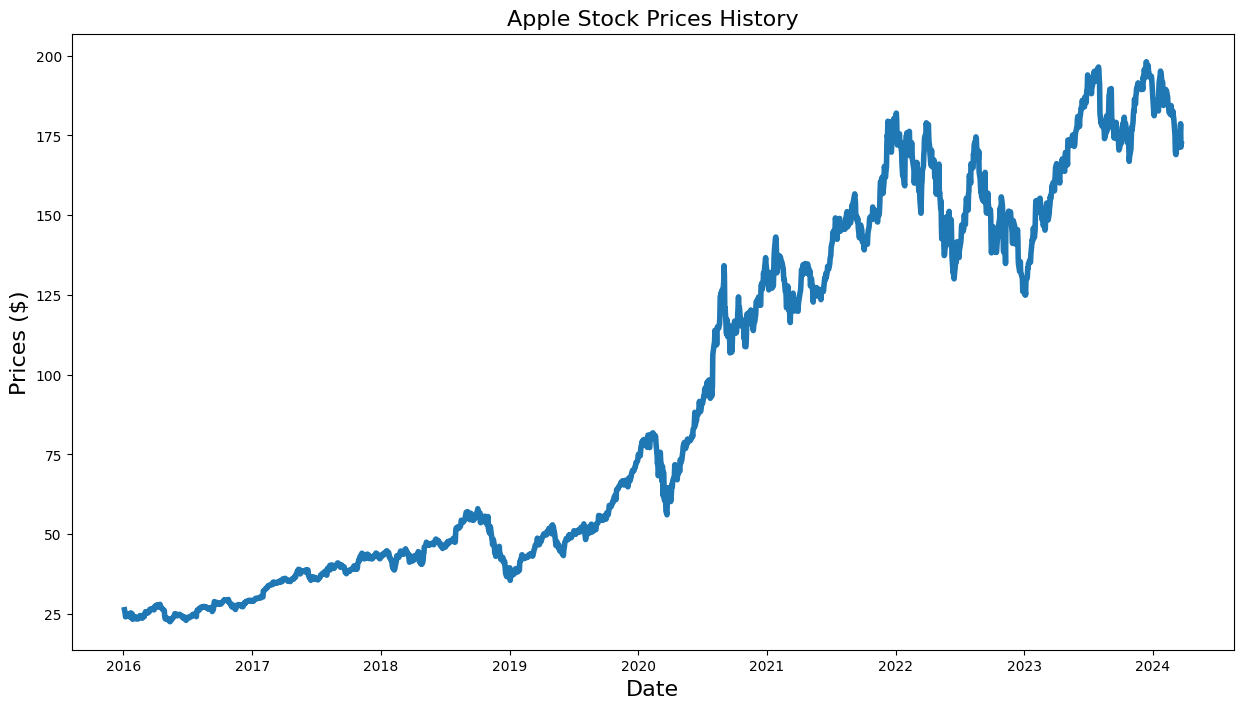

In [12]:
plt.figure(figsize=(15, 8))
plt.title('Apple Stock Prices History', fontsize = 16)
plt.plot(stock_data['Close'], linewidth = 4)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Prices ($)', fontsize = 16)

# Visualizing the Predicted Prices

<ipython-input-13-f54e11857a30>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


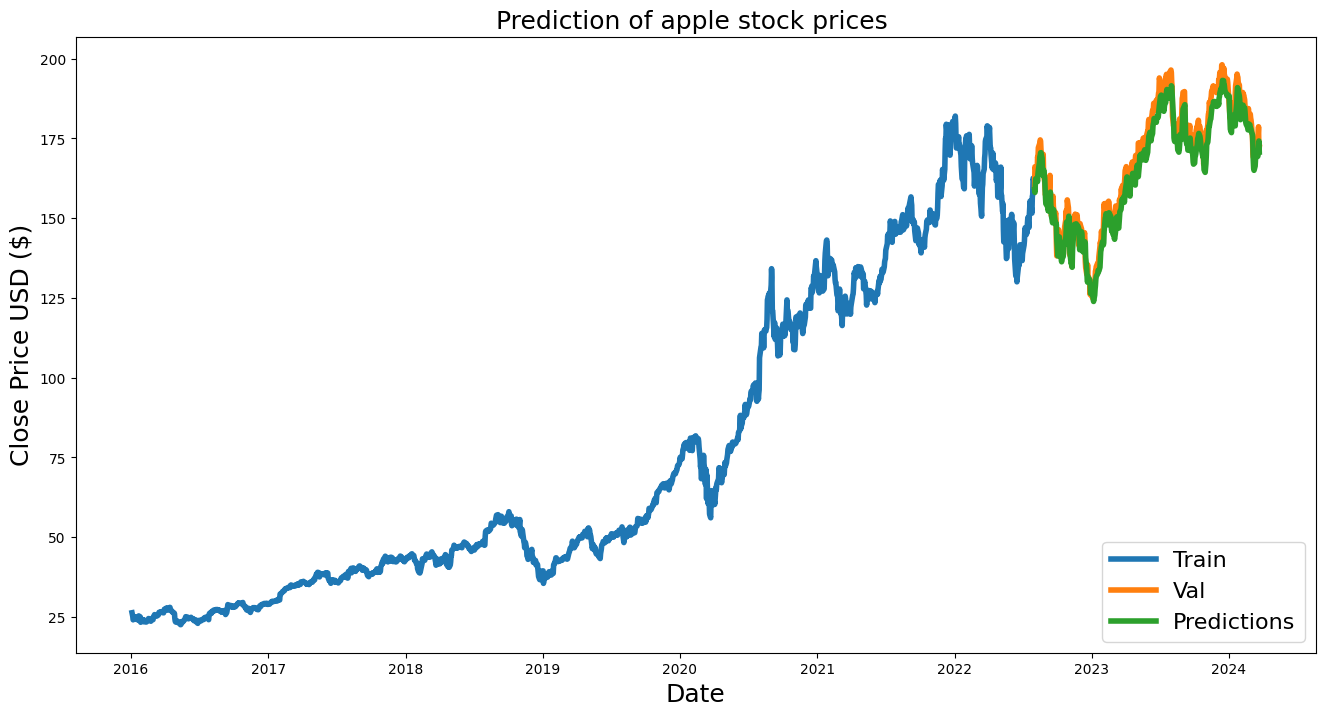

In [13]:
#Use the filter method to only retain the closing price column in the dataframe
data = stock_data.filter(['Close'])

#Split the stock data into three plotting regions: training, validation and prediction
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Prediction of apple stock prices ', fontsize = 18)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.plot(train, linewidth = 4)
plt.plot(validation[['Close', 'Predictions']], linewidth = 4)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right', fontsize = 16)
plt.show()

From the above graph we can see the predicted stock prices follow the trend of the real stock prices closely.

This shows the effectiveness of the LSTM for sequential or time series data such as stock price.